In [202]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import spectrogram, butter, firwin, lfilter, filtfilt, freqz
from scipy.fft import fft
from scipy import pi, signal
from sklearn.decomposition import FastICA
from scipy.signal import welch

data_path = './s1_s1_ec.csv'

df = pd.read_csv(data_path)

display(df.head())
print(f'Dimensi Data: {df.shape}')

,F3,FC5,AF3,F7,T7,P7,O1,O2,P8,T8,F8,AF4,FC6,F4,Timestamp,Date,Time
0,4197.948718,4173.974359,4187.564102,4187.051282,4196.153846,4199.230769,4185.000000,4203.589744,4204.871795,4195.512820,4156.666666,4199.487179,4187.564102,4199.102564,14-04-2018 12:01:43.828,14-04-2018,12:01:43.828
1,4199.102564,4172.564102,4190.128205,4176.282051,4188.461538,4202.820513,4186.282051,4202.692308,4203.974359,4198.333333,4185.769231,4192.820513,4185.000000,4198.461538,14-04-2018 12:01:43.828,14-04-2018,12:01:43.828
2,4190.512820,4171.666667,4184.615384,4185.769231,4186.538461,4202.692308,4186.923077,4198.846154,4199.871795,4187.051282,4200.897436,4180.000000,4185.641026,4189.871795,14-04-2018 12:01:43.831,14-04-2018,12:01:43.831
3,4189.615384,4168.717949,4186.666667,4182.820513,4187.692308,4195.769231,4185.897436,4198.589743,4201.410256,4183.846154,4166.923077,4198.333333,4191.025641,4198.846154,14-04-2018 12:01:43.832,14-04-2018,12:01:43.832
4,4198.846154,4176.666667,4193.205128,4184.230769,4184.743590,4202.051282,4189.743590,4203.846154,4203.461538,4198.846154,4196.666667,4194.743590,4193.846154,4196.923077,14-04-2018 12:01:43.832,14-04-2018,12:01:43.832


Dimensi Data: (30720, 17)


In [203]:
def cutoff(data, baseline = 5119, duration = 120, sampling = 256):
    dur = (duration * sampling)
    cut = data[baseline:baseline+dur]

    eeg = np.array([
        cut["AF3"].values,
        cut["AF4"].values,
        cut["O1"].values,
        cut["O2"].values,
    ])

    return eeg

In [204]:
dataRAW = cutoff(df)
print(dataRAW)
print(dataRAW.shape)
print(type(dataRAW))

[[4202.43589737 4202.05128199 4202.5641025  ... 4125.64102537
  4123.46153819 4120.51282024]
 [4210.38461532 4207.43589737 4204.23076917 ... 4160.25641005
  4154.87179467 4149.48717928]
 [4185.89743576 4187.69230756 4188.58974345 ... 4172.30769217
  4171.41025628 4170.76923063]
 [4201.15384609 4201.53846147 4200.76923063 ... 4148.71794851
  4150.38461518 4148.97435877]]
(4, 25601)
<class 'numpy.ndarray'>


In [205]:
def normalize(x):
    xmin = min(x)
    xmax = max(x)
    maxamp = 0
    xnorm = 0

    if (abs(xmax) >= abs(xmin)):
        maxamp = abs(xmax)
    else:
        maxamp = abs(xmin)

    if (xmin == xmax):
        return 'Cannot normalize the signal.'
    else:
        xnorm = x / maxamp
        return xnorm

def normalize_eeg(data, channel_num = 4):

    eeg_norm = []
    for i in range(channel_num):
        s = normalize(data[i])
        s.transpose()
        s = list(s)
        eeg_norm.append(s)

    return np.asarray(eeg_norm)

Text(0, 0.5, 'Normalized Amplitude')

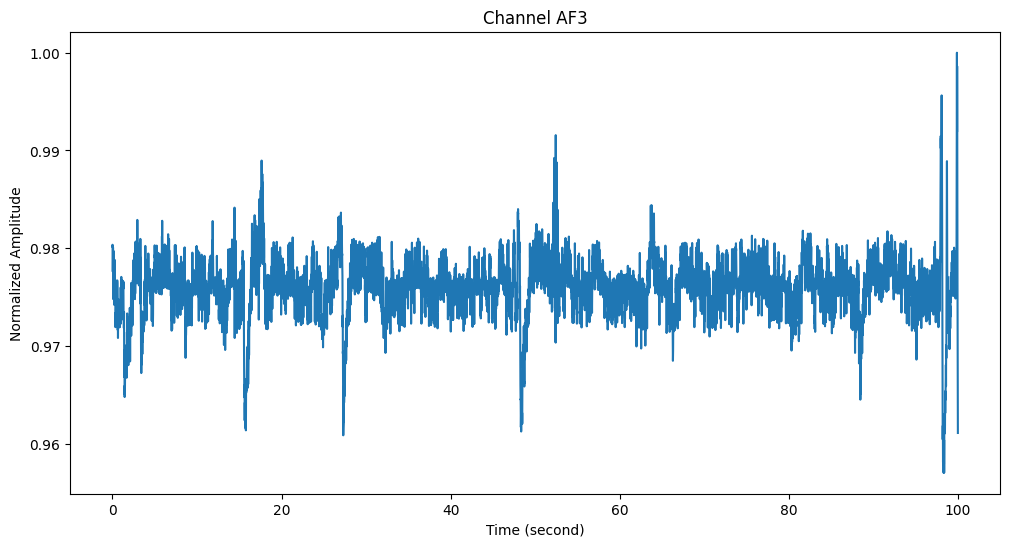

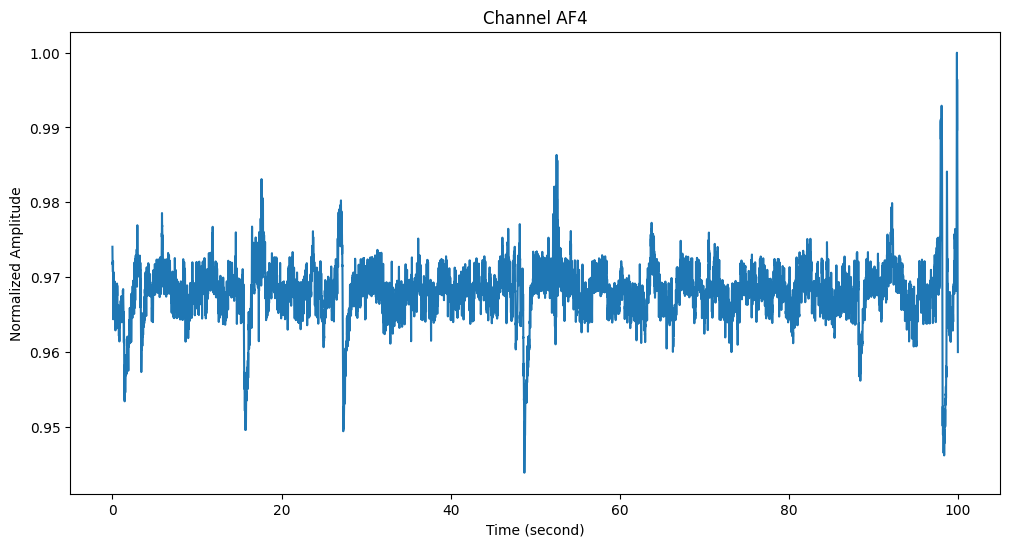

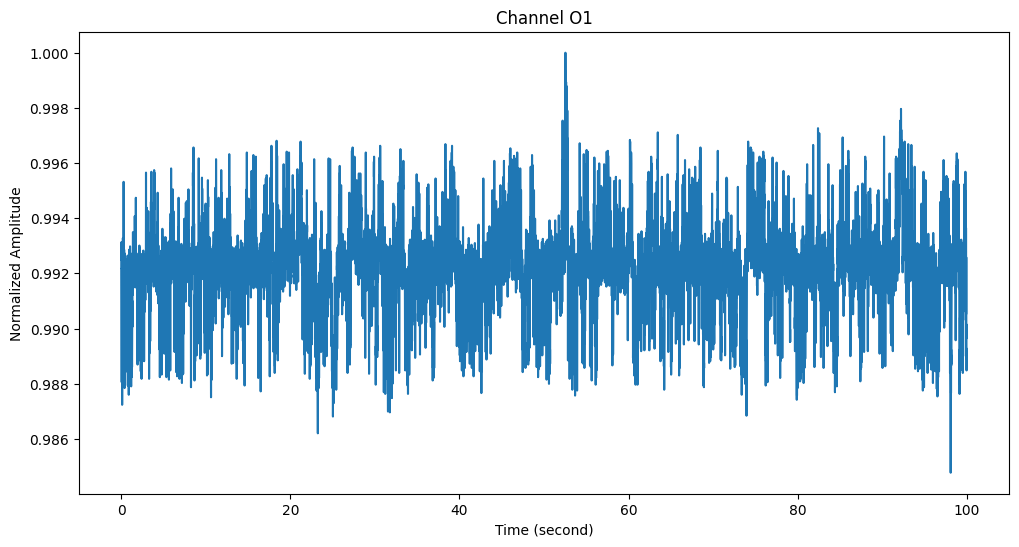

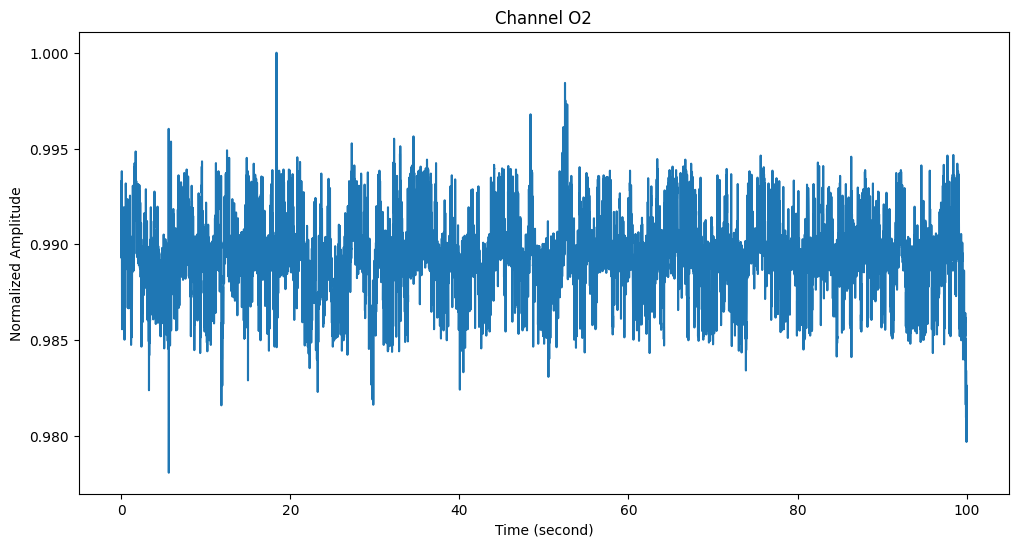

In [206]:
dataHASIL = normalize_eeg(dataRAW)
times = np.arange(len(dataHASIL[0]))/256

plt.figure(figsize=(12, 6))
plt.plot(times,dataHASIL[0])
plt.title('Channel AF3')
plt.xlabel('Time (second)')
plt.ylabel('Normalized Amplitude')

plt.figure(figsize=(12, 6))
plt.plot(times,dataHASIL[1])
plt.title('Channel AF4')
plt.xlabel('Time (second)')
plt.ylabel('Normalized Amplitude')

plt.figure(figsize=(12, 6))
plt.plot(times,dataHASIL[2])
plt.title('Channel O1')
plt.xlabel('Time (second)')
plt.ylabel('Normalized Amplitude')

plt.figure(figsize=(12, 6))
plt.plot(times,dataHASIL[3])
plt.title('Channel O2')
plt.xlabel('Time (second)')
plt.ylabel('Normalized Amplitude')

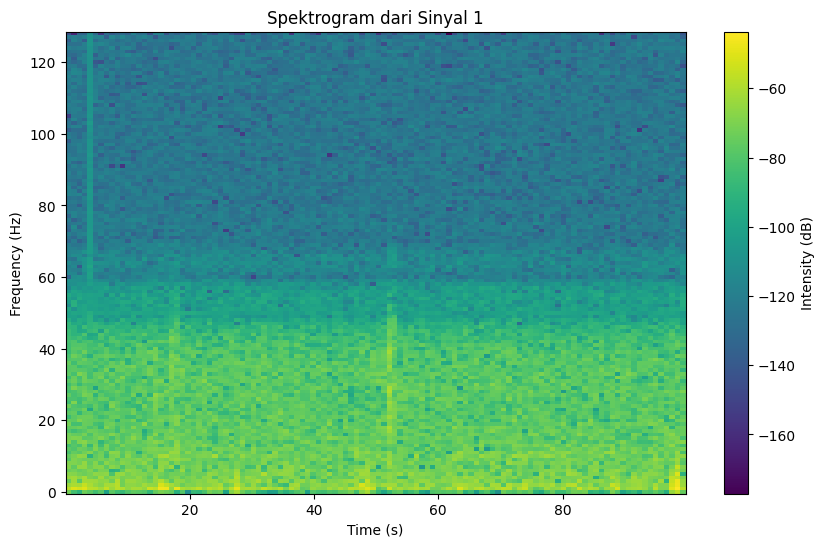

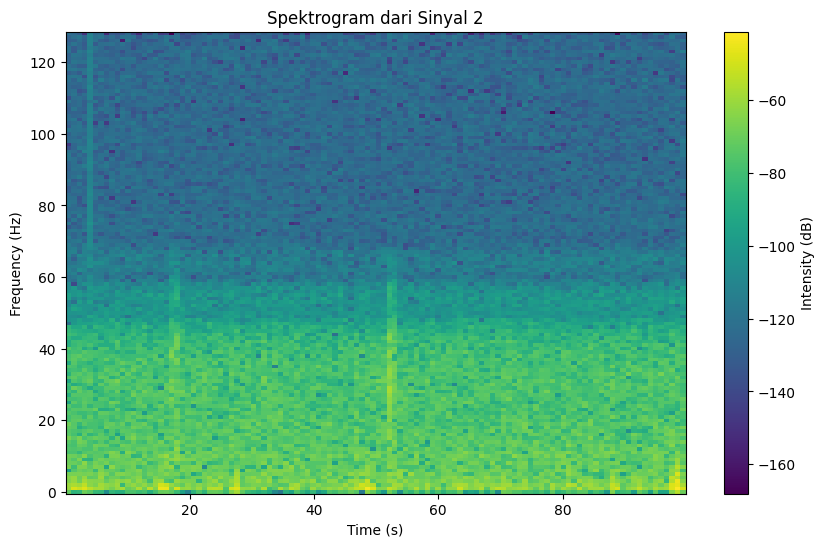

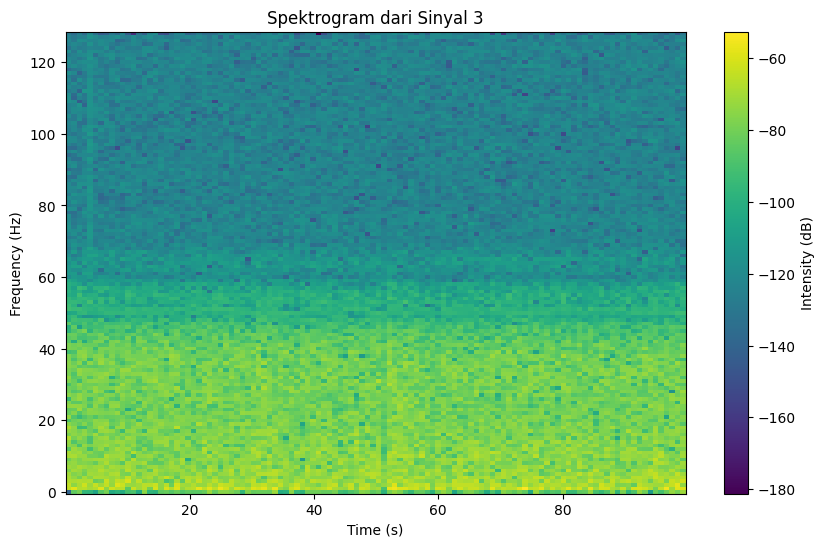

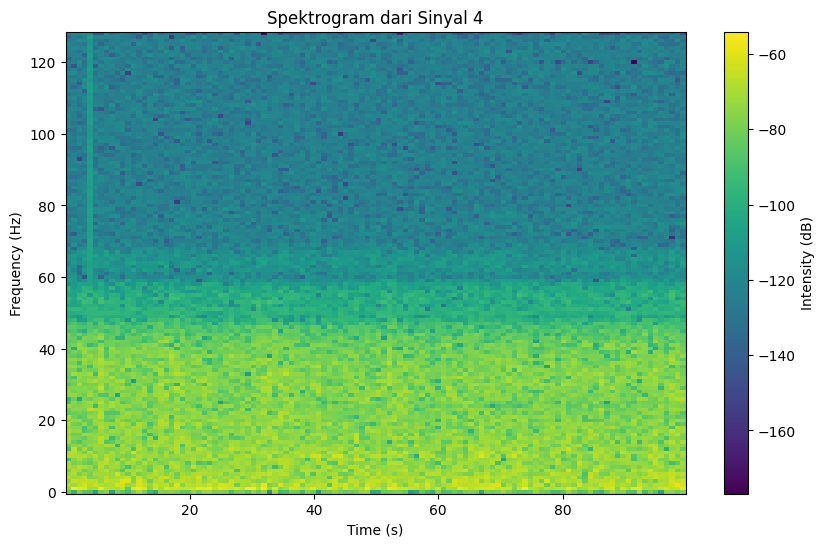

In [207]:
for i in range(4) :
    T = len(times)/256
    freqs, t, Sxx = spectrogram(dataHASIL[i], fs=256)

    plt.figure(figsize=(10, 6))
    plt.pcolormesh(t, freqs, 10 * np.log10(Sxx), shading='auto')
    plt.colorbar(label='Intensity (dB)')
    plt.title(f'Spektrogram dari Sinyal {i+1}')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.show()